# NLP Exploration for Equip Rail

In [1]:
import pandas as pd
import numpy as np

import acquire
import prepare
import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
#Acquire the data
df = acquire.get_equiprail()
df.head()

,IYR,IMO,RAILROAD,INCDTNO,IYR2,IMO2,RR2,INCDTNO2,IYR3,IMO3,...,RCL,Latitude,Longitud,SIGNAL,MOPERA,ADJUNCT1,ADJUNCT2,ADJUNCT3,SUBDIV,Unnamed: 145
0,12,5,BNSF,GC0512102,NaN,NaN,NaN,NaN,12,5,...,0.0,29.755900,-95.293100,1,1,G,NaN,NaN,NORTH SHORE,NaN
1,12,5,BNSF,GC0512105,NaN,NaN,NaN,NaN,12,5,...,0.0,29.500571,-95.597089,2,5,Z,NaN,NaN,GALVESTON,NaN
2,12,2,NS,98074,12.0,2.0,CSX,100906,12,2,...,NaN,34.612981,-86.988133,1,1,B,NaN,NaN,ALABAMA,NaN
3,12,5,BNSF,GC0512106,NaN,NaN,NaN,NaN,12,5,...,0.0,31.446576,-96.207606,2,5,Z,NaN,NaN,HOUSTON,NaN
4,12,5,BNSF,GC0512112,NaN,NaN,NaN,NaN,12,5,...,0.0,29.772155,-95.384013,2,5,Z,NaN,NaN,HOUSTON,NaN


In [3]:
df = prepare.equip_nlp()
df.head(1)

,RAILROAD,narrative
0,BNSF,Y-HOU38810-04 DERAILED 1 CAR WHILE DOUBLING FROM PTRA NORTH YARD. DOWNLOADS SHOWS ENG...


In [4]:
def clean_nlp(narrative):
    'A simple function to cleanup text data'
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt', '\n', 'ha']
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')+ ADDITIONAL_STOPWORDS
    narrative = (unicodedata.normalize('NFKD', narrative)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', narrative).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

# seperate the data into seperate pieces 
up = clean_nlp(' '.join(df[df.RAILROAD == 'UP'].narrative))
csx = clean_nlp(' '.join(df[df.RAILROAD == 'CSX'].narrative))
ns = clean_nlp(' '.join(df[df.RAILROAD == 'NS'].narrative))
bnsf = clean_nlp(' '.join(df[df.RAILROAD == 'BNSF'].narrative))
atk = clean_nlp(' '.join(df[df.RAILROAD == 'ATK'].narrative))
kcs = clean_nlp(' '.join(df[df.RAILROAD == 'KCS'].narrative))
allrails = clean_nlp(' '.join(df.narrative))

In [5]:
# transform into a pandas series
up_freq = pd.Series(up).value_counts()
csx_freq = pd.Series(csx).value_counts()
ns_freq = pd.Series(ns).value_counts()
bnsf_freq = pd.Series(bnsf).value_counts()
atk_freq = pd.Series(atk).value_counts()
kcs_freq = pd.Series(kcs).value_counts()
all_freq = pd.Series(allrails).value_counts()


In [6]:
# create a dataframe with all three columns showing frequency counts
word_counts = (pd.concat([all_freq, up_freq, csx_freq, ns_freq, bnsf_freq ,atk_freq, kcs_freq], axis=1, sort=True)
                .set_axis(['all', 'UP', 'CSX', 'NS', 'BNSF', 'ATK', 'KCS'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.tail()

,all,UP,CSX,NS,BNSF,ATK,KCS
zycmxb27,2,2,0,0,0,0,0
zycmxc29,1,1,0,0,0,0,0
zycsa30,1,1,0,0,0,0,0
zycsl07,1,1,0,0,0,0,0
zyx,1,0,0,1,0,0,0


In [7]:
# sort values by all
word_counts.sort_values(by='all', ascending=False).head(10)

,all,UP,CSX,NS,BNSF,ATK,KCS
car,20538,9460,5170,2464,2199,819,426
track,16472,7167,2780,1174,4546,550,255
derailed,9396,3482,1184,1269,3034,212,215
train,6501,2885,895,944,661,897,219
switch,5374,2643,974,458,1034,178,87
due,4617,1166,382,136,2758,149,26
yard,4167,1191,572,348,1833,180,43
damage,4048,1818,583,122,807,666,52
lead,3770,2373,555,452,186,174,30
locomotive,3480,1543,252,255,826,593,11


In [8]:
# look for any words that are unique to a rail company
pd.concat([word_counts[word_counts.UP == 0].sort_values(by='UP').tail(6),
           word_counts[word_counts.CSX == 0].sort_values(by='CSX').tail(6),
          word_counts[word_counts.NS == 0].sort_values(by='NS').tail(6),
          word_counts[word_counts.BNSF == 0].sort_values(by='BNSF').tail(6),
          word_counts[word_counts.ATK == 0].sort_values(by='ATK').tail(6),
          word_counts[word_counts.KCS == 0].sort_values(by='KCS').tail(6)])

,all,UP,CSX,NS,BNSF,ATK,KCS
9174,1,0,0,0,1,0,0
9172,1,0,0,0,1,0,0
917,2,0,0,0,0,2,0
9162,2,0,0,2,0,0,0
918207,2,0,2,0,0,0,0
zyx,1,0,0,1,0,0,0
cfgat9,1,1,0,0,0,0,0
cfe,5,0,0,5,0,0,0
cf891,1,0,0,1,0,0,0
cf3919,1,0,0,1,0,0,0


**Union Pacific Bigram**

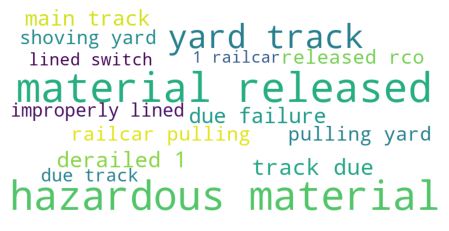

In [9]:
#Create a bigram of words
top_15_BNSF_bigrams = (pd.Series(nltk.ngrams(bnsf, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_BNSF_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

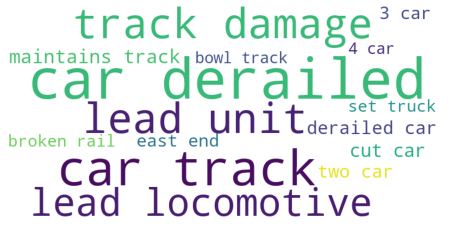

In [10]:
#Create a bigram of words
top_15_UP_bigrams = (pd.Series(nltk.ngrams(up, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_UP_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

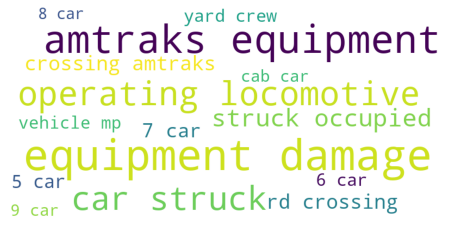

In [11]:
#Create a bigram of words
top_15_ATK_bigrams = (pd.Series(nltk.ngrams(atk, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_ATK_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

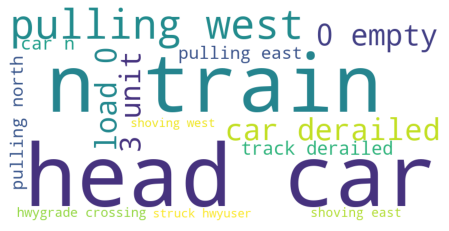

In [12]:
#Create a bigram of words
top_15_NS_bigrams = (pd.Series(nltk.ngrams(ns, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_NS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

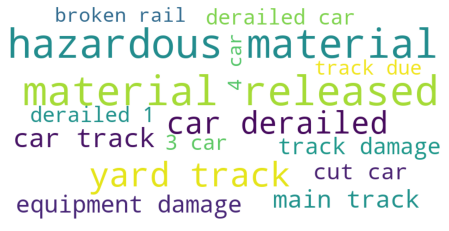

In [13]:
#Create a bigram of words
top_15_all_bigrams = (pd.Series(nltk.ngrams(allrails, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

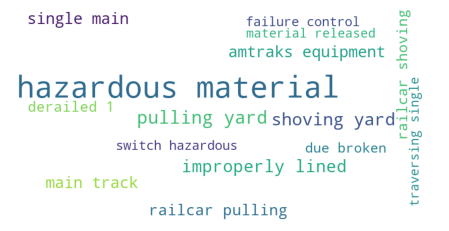

In [14]:
#Create a trigram of words
top_15_all_trigrams = (pd.Series(nltk.ngrams(allrails, 3)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_all_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

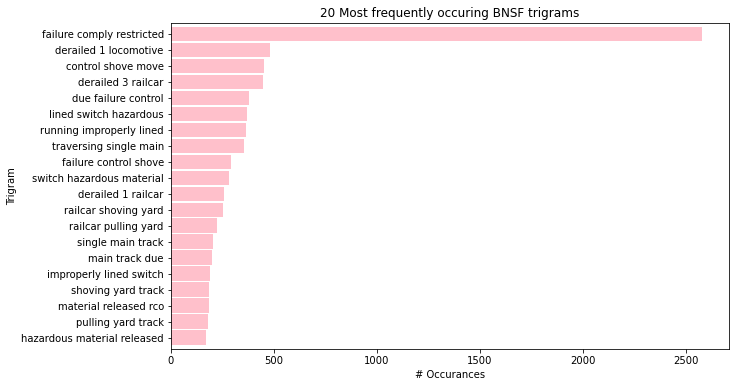

In [15]:
trigrams_bnsf = nltk.ngrams(bnsf, 3)
top_20_bnsf_trigrams = pd.Series(trigrams_bnsf).value_counts().head(20)

top_20_bnsf_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring BNSF trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bnsf_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2] )
_ = plt.yticks(ticks, labels)
plt.savefig("nbsf_trigrams.jpeg")

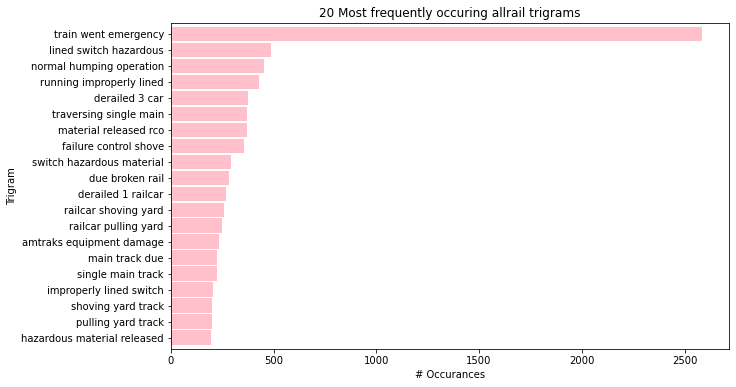

In [16]:
trigrams_allrail = nltk.ngrams(allrails, 3)
top_20_allrail_trigrams = pd.Series(trigrams_allrail).value_counts().head(20)

top_20_allrail_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
plt.title('20 Most frequently occuring allrail trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')
# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_allrail_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2] )
_ = plt.yticks(ticks, labels)
plt.savefig("Allrail_trigrams.jpeg")